# 목표
- 태양풍 데이터를 3시간씩 mean, min, max 값을 내서 target과 concat함
- x,y,z, total만 사용

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mino
import sklearn
import pickle

In [2]:
%load_ext watermark

In [3]:
%watermark -ajinhyo -u -d -v -pnumpy,pandas,matplotlib,seaborn,missingno,sklearn

jinhyo 
last updated: 2019-09-10 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
pandas 0.24.2
matplotlib 3.0.3
seaborn 0.9.0
missingno 0.4.2
sklearn 0.20.3


---

# 데이터 불러오기

In [64]:
# 붙임1 지자기교란 예측모델 개발용 데이터셋_수정190820/지자기교란 지수

target = pd.read_csv("kp_1999-2013.csv")
target.head()

,date,kp_0h,kp_3h,kp_6h,kp_9h,kp_12h,kp_15h,kp_18h,kp_21h
0,1999-01-01,0,2,1,2,2,1,1,1
1,1999-01-02,1,2,2,3,3,2,2,1
2,1999-01-03,2,2,0,0,1,1,1,1
3,1999-01-04,1,2,3,2,3,2,1,2
4,1999-01-05,3,3,2,3,1,1,2,1


In [5]:
# 붙임2 AI 경진대회 문제(태양풍 데이터)

problem = pd.read_csv("problem.csv")
problem.head()

,doy,h,m,Np,Tp,Vp,B_gsm_x,B_gsm_y,B_gsm_z,Bmag
0,1,0,0,1.852,41618.0,455.61,6.098,2.449,-13.415,14.952
1,1,0,1,2.181,33781.0,461.07,6.700,1.502,-13.232,14.912
2,1,0,2,2.415,34709.0,464.84,7.390,0.523,-12.941,14.928
3,1,0,3,2.359,34183.0,470.76,8.011,-0.098,-12.694,15.013
4,1,0,4,1.237,32467.0,469.51,7.493,0.410,-13.058,15.064


In [6]:
# 붙임5 추가 태양풍 데이터(과제문제의 전년도 6개월)

additional = pd.read_csv("additional.csv", skiprows=14, delim_whitespace=True, names=problem.columns)
additional.head()

,doy,h,m,Np,Tp,Vp,B_gsm_x,B_gsm_y,B_gsm_z,Bmag
0,180,0,1,2.416,65701.0,402.18,-4.212,-3.982,2.445,6.298
1,180,0,2,2.493,68240.0,399.89,-4.566,-3.473,2.766,6.430
2,180,0,3,2.582,85224.0,389.17,-5.456,-2.370,2.837,6.596
3,180,0,4,2.686,90925.0,390.59,-5.550,-1.988,2.768,6.519
4,180,0,5,2.676,79821.0,392.44,-4.922,-3.073,2.679,6.416


In [7]:
# 붙임5의 columns를 카피함.

names = ["year"]
names.extend(problem.columns)
names

['year',
 'doy',
 'h',
 'm',
 'Np',
 'Tp',
 'Vp',
 'B_gsm_x',
 'B_gsm_y',
 'B_gsm_z',
 'Bmag']

In [8]:
# 붙임1 지자기교란 예측모델 개발용 데이터셋_수정190820/태양풍

ace = {}
for y in range(1999, 2014):
    ace[y] = pd.read_csv(f"ace_{y}.csv", skiprows=15, delim_whitespace=True, names=names)

ace[1999].head(5)

,year,doy,h,m,Np,Tp,Vp,B_gsm_x,B_gsm_y,B_gsm_z,Bmag
0,1999,1,0,0,7.149,92352.0,406.00,-2.174,-2.598,5.550,6.630
1,1999,1,0,1,5.998,85859.0,419.12,-1.245,-0.140,6.558,6.796
2,1999,1,0,2,6.211,81547.0,411.99,-2.003,-1.198,6.306,6.802
3,1999,1,0,3,6.680,72308.0,405.25,-3.093,-2.483,5.545,6.854
4,1999,1,0,4,-9999.900,-9999.9,-9999.90,-3.009,-1.500,5.908,6.842


---

# ace에 target을 분단위로 concat

> ace 전처리

In [9]:
total_train = pd.concat(ace.values(), axis=0)

In [10]:
total_train["date"] = pd.to_datetime(total_train["year"], format='%Y') + \
                    total_train.doy.apply(pd.Timedelta, unit="d") - \
                    pd.Timedelta(1, unit="d")

In [11]:
total_train["kp_h"] = total_train.h.map({
                        0:"kp_00h",    1:"kp_00h",    2:"kp_00h",
                        3:"kp_03h",    4:"kp_03h",    5:"kp_03h",
                        6:"kp_06h",    7:"kp_06h",    8:"kp_06h",
                        9:"kp_09h",    10:"kp_09h",    11:"kp_09h",
                        12:"kp_12h",    13:"kp_12h",    14:"kp_12h",
                        15:"kp_15h",    16:"kp_15h",    17:"kp_15h",
                        18:"kp_18h",    19:"kp_18h",    20:"kp_18h",
                        21:"kp_21h",    22:"kp_21h",    23:"kp_21h",
                                  })

In [12]:
total_train["idx"] = total_train.date.astype(str).str.split(" ").rename(columns={0:"date"}).drop(columns=[1])

In [18]:
total_train["idx"] = total_train.idx.map(lambda x: x[0])

In [19]:
total_train["idx"] = total_train["idx"] + total_train["kp_h"]

> target 전처리

In [20]:
target_origin = target.copy()

In [21]:
# kp_h명 바꾸기
cols = {
    "kp_0h":"kp_00h",
    "kp_3h":"kp_03h",
    "kp_6h":"kp_06h",
    "kp_9h":"kp_09h",
}
target.rename(columns=cols, inplace=True)

In [22]:
target = target.melt("date").rename(columns={"variable":"kp_h", "value":"target"})

In [24]:
target["idx"] = target["date"] + target["kp_h"]

> ace와 target merge

In [26]:
data = pd.merge(total_train, target, on=["idx"], how="outer")

In [27]:
len(total_train), len(data)

(7429504, 7429504)

In [29]:
data_origin = data.copy()

In [30]:
data = data.drop(columns=["year", "doy", "h", "m", "idx", "date_y", "kp_h_y"])

In [33]:
data.rename(columns={"date_x":"date", "kp_h_y":"kp_h"}, inplace=True)

In [34]:
data.to_csv("ace_target_merged.csv")

In [4]:
data = pd.read_csv("ace_target_merged.csv", index_col=0)

C:\Users\JINHYO\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
data.head()

,Np,Tp,Vp,B_gsm_x,B_gsm_y,B_gsm_z,Bmag,date,kp_h_x,target
0,7.149,92352.0,406.00,-2.174,-2.598,5.550,6.630,1999-01-01,kp_00h,0
1,5.998,85859.0,419.12,-1.245,-0.140,6.558,6.796,1999-01-01,kp_00h,0
2,6.211,81547.0,411.99,-2.003,-1.198,6.306,6.802,1999-01-01,kp_00h,0
3,6.680,72308.0,405.25,-3.093,-2.483,5.545,6.854,1999-01-01,kp_00h,0
4,-9999.900,-9999.9,-9999.90,-3.009,-1.500,5.908,6.842,1999-01-01,kp_00h,0


# 시각화 분석

In [ ]:
# sns.pairplot(data.drop(columns=["Np", "Tp"]), hue="target")

In [54]:
data.groupby("target").min()

,Np,Tp,Vp,B_gsm_x,B_gsm_y,B_gsm_z,Bmag,date,kp_h_x
target,,,,,,,,,
0,-9999.9004,-9999.9004,-9999.9004,-9999.9004,-9999.9004,-9999.9004,-9999.9004,1999-01-01,kp_00h
1,-9999.9004,-9999.9004,-9999.9004,-9999.9004,-9999.9004,-9999.9004,-9999.9004,1999-01-01,kp_00h
2,-9999.9004,-9999.9004,-9999.9004,-9999.9004,-9999.9004,-9999.9004,-9999.9004,1999-01-01,kp_00h
3,-9999.9004,-9999.9004,-9999.9004,-9999.9000,-9999.9000,-9999.9000,-9999.9000,1999-01-02,kp_00h
4,-9999.9004,-9999.9004,-9999.9004,-9999.9000,-9999.9000,-9999.9000,-9999.9000,1999-01-08,kp_00h
5,-9999.9004,-9999.9004,-9999.9004,-9999.9000,-9999.9000,-9999.9000,-9999.9000,1999-01-13,kp_00h
6,-9999.9004,-9999.9004,-9999.9004,-53.2790,-45.8300,-34.4770,0.9580,1999-01-13,kp_00h
7,-9999.9004,-9999.9004,-9999.9004,-42.0190,-46.8910,-52.9260,1.5390,1999-02-18,kp_00h
8,-9999.9000,-9999.9000,-9999.9000,-9999.9000,-9999.9000,-9999.9000,-9999.9000,1999-10-22,kp_00h


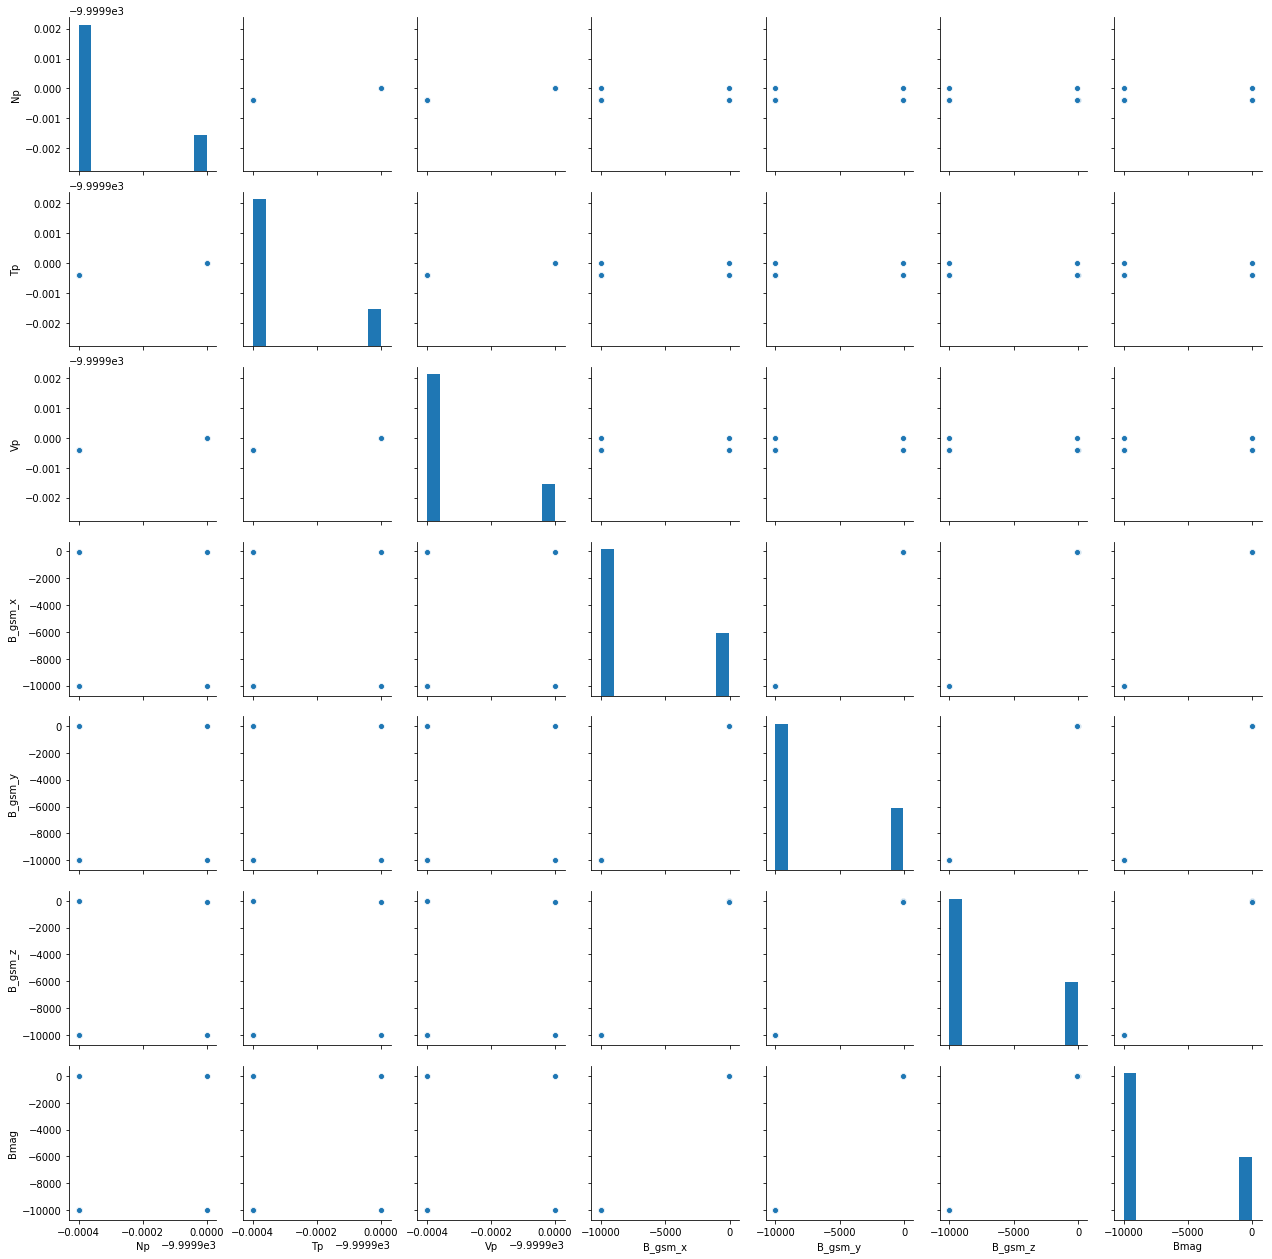

In [55]:
sns.pairplot(data.groupby("target").min())

In [50]:
data.groupby("target").mean()

,Np,Tp,Vp,B_gsm_x,B_gsm_y,B_gsm_z,Bmag
target,,,,,,,
0,-6616.270727,21166.528131,-618.274599,-10.394187,-10.831813,-9.845554,-6.709612
1,-5130.758449,41700.885191,-414.356687,-6.438602,-6.682839,-6.097579,-1.971287
2,-3336.528168,70052.411387,-227.685375,-3.703131,-3.919683,-3.629631,1.826001
3,-1967.447191,105391.588190,-119.249319,-5.499930,-5.574205,-5.880590,1.186009
4,-1485.889626,142333.254115,-81.669178,-6.795609,-6.360576,-7.715741,1.682395
5,-1459.305997,159947.197732,-211.364489,-0.594853,0.740810,-2.521534,9.952396
6,-1602.993165,148552.173946,-289.832774,-0.245737,1.258484,-4.041342,13.114243
7,-1990.662145,173233.005956,-992.176980,-0.720757,1.989922,-5.360296,19.121267
8,-3053.524593,160006.821378,-1712.979073,-4.223935,-1.705562,-13.106914,22.192538


{'whiskers': [<matplotlib.lines.Line2D at 0x2553ea7aeb8>,
 'caps': [<matplotlib.lines.Line2D at 0x2553ea87588>,
 'boxes': [<matplotlib.lines.Line2D at 0x2553ea7aa90>,
 'medians': [<matplotlib.lines.Line2D at 0x2553ea87c18>,
 'fliers': [<matplotlib.lines.Line2D at 0x2553ea87f60>,
 'means': []}

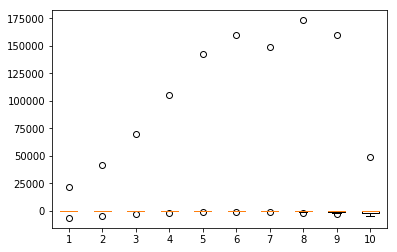

In [49]:
plt.boxplot(data.groupby("target").mean())

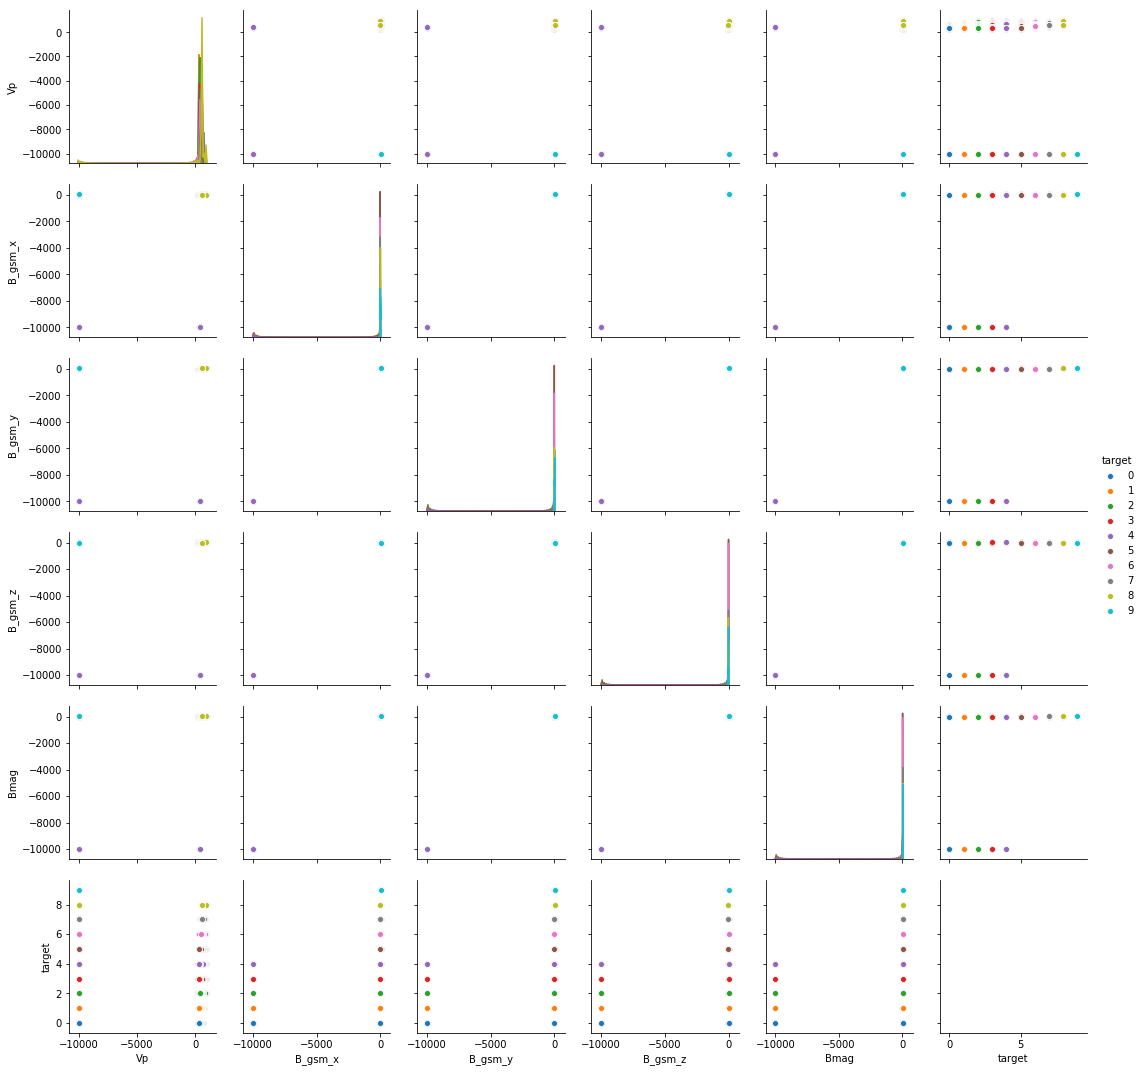

In [53]:
sns.pairplot(data.drop(columns=["Np", "Tp"]).iloc[:1_000_000, :], hue="target")

In [43]:
len(data)

7429504

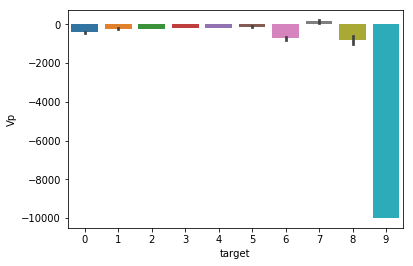

In [44]:
sns.barplot(x="target", y="Vp", data=data.iloc[:1_000_000,:])

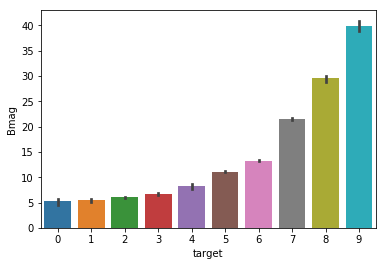

In [46]:
sns.barplot(x="target", y="Bmag", data=data.iloc[:1_000_000,:])

----

# 결측값을 None으로 바꿈

In [6]:
data["Np_"] = data.Np.map(lambda x: x if x > 0 else None)
data["Tp_"] = data.Tp.map(lambda x: x if x > 0 else None)
data["Vp_"] = data.Vp.map(lambda x: x if x > 0 else None)

In [7]:
change2none = ['date', 'kp_h_x','Np_', 'Tp_', 'Vp_','B_gsm_x', 'B_gsm_y', 'B_gsm_z', 'Bmag',  'target']

> groupby.count

In [102]:
data[change2none][data[change2none]["Np_"].isnull()].groupby("target").count()

,date,kp_h_x,Np_,Tp_,Vp_,B_gsm_x,B_gsm_y,B_gsm_z,Bmag
target,,,,,,,,,
0,690979,690979,0,169466,592974,690979,690979,690979,690979
1,996305,996305,0,357572,847236,996305,996305,996305,996305
2,666241,666241,0,269874,542471,666241,666241,666241,666241
3,299715,299715,0,127321,214983,299715,299715,299715,299715
4,93359,93359,0,44174,58032,93359,93359,93359,93359
5,30990,30990,0,13410,16013,30990,30990,30990,30990
6,10135,10135,0,4559,5144,10135,10135,10135,10135
7,4017,4017,0,826,1009,4017,4017,4017,4017
8,2068,2068,0,374,543,2068,2068,2068,2068


In [103]:
data[change2none][data[change2none]["Tp_"].isnull()].groupby("target").count()

,date,kp_h_x,Np_,Tp_,Vp_,B_gsm_x,B_gsm_y,B_gsm_z,Bmag
target,,,,,,,,,
0,522872,522872,1359,0,425187,522872,522872,522872,522872
1,642125,642125,3392,0,494092,642125,642125,642125,642125
2,400716,400716,4349,0,277822,400716,400716,400716,400716
3,176174,176174,3780,0,91915,176174,176174,176174,176174
4,50714,50714,1529,0,15521,50714,50714,50714,50714
5,18133,18133,553,0,3189,18133,18133,18133,18133
6,5758,5758,182,0,784,5758,5758,5758,5758
7,3246,3246,55,0,239,3246,3246,3246,3246
8,1717,1717,23,0,191,1717,1717,1717,1717


In [104]:
data[change2none][data[change2none]["Vp_"].isnull()].groupby("target").count()

,date,kp_h_x,Np_,Tp_,Vp_,B_gsm_x,B_gsm_y,B_gsm_z,Bmag
target,,,,,,,,,
0,98310,98310,305,625,0,98310,98310,98310,98310
1,150593,150593,1524,2560,0,150593,150593,150593,150593
2,126457,126457,2687,3563,0,126457,126457,126457,126457
3,87280,87280,2548,3021,0,87280,87280,87280,87280
4,36420,36420,1093,1227,0,36420,36420,36420,36420
5,15325,15325,348,381,0,15325,15325,15325,15325
6,5062,5062,71,88,0,5062,5062,5062,5062
7,3042,3042,34,35,0,3042,3042,3042,3042
8,1531,1531,6,5,0,1531,1531,1531,1531


In [108]:
# problem에서 Np, Tp, Vp가 모두 결측값인 row의 갯수

mightNine = problem[problem["Np"]<0]
mightNine = mightNine[mightNine["Tp"]<0]
mightNine = mightNine[mightNine["Vp"]<0]
len(mightNine)

25267

> groupby.mean

In [109]:
data[change2none][data[change2none]["Np_"].isnull()].groupby("target").mean()

,Np_,Tp_,Vp_,B_gsm_x,B_gsm_y,B_gsm_z,Bmag
target,,,,,,,
0,NaN,46643.908631,330.108948,-15.696745,-16.333268,-15.362674,-12.256689
1,NaN,60029.560451,355.337486,-11.834854,-12.281203,-11.784075,-7.641864
2,NaN,85379.674178,385.870993,-8.470971,-9.061724,-8.926770,-3.311646
3,NaN,121294.052276,425.055868,-22.236233,-22.793968,-23.352766,-15.880770
4,NaN,144939.444957,470.241264,-35.782869,-36.673441,-37.976053,-27.608663
5,NaN,162786.688273,484.673199,-0.700316,-0.585416,-3.392786,9.875913
6,NaN,136114.298212,487.336052,0.995496,1.000574,-3.855597,14.386703
7,NaN,146154.581477,585.355649,-2.968377,1.598904,-3.044749,20.995321
8,NaN,250533.508021,665.011271,-19.067504,-11.253680,-22.672210,14.179373


In [110]:
data[change2none][data[change2none]["Tp_"].isnull()].groupby("target").mean()

,Np_,Tp_,Vp_,B_gsm_x,B_gsm_y,B_gsm_z,Bmag
target,,,,,,,
0,3.820259,NaN,316.131411,-20.496382,-21.056757,-20.202385,-17.061035
1,4.397577,NaN,329.089420,-17.051552,-17.364384,-17.047283,-12.828182
2,4.987266,NaN,342.252223,-13.238297,-13.715218,-13.646404,-7.896803
3,5.615963,NaN,357.268531,-38.087293,-38.549916,-39.088989,-31.440162
4,5.628788,NaN,399.331146,-66.609470,-66.932506,-68.641227,-58.255811
5,5.790153,NaN,431.057065,-1.092744,-0.717955,-3.089339,9.767630
6,7.257171,NaN,470.254670,-0.057796,1.700415,-3.544385,13.794285
7,8.598000,NaN,444.608870,-4.002286,0.051679,-1.967939,22.028947
8,7.239522,NaN,694.521728,-4.230888,1.202974,-7.765692,29.777639


In [111]:
data[change2none][data[change2none]["Vp_"].isnull()].groupby("target").mean()

,Np_,Tp_,Vp_,B_gsm_x,B_gsm_y,B_gsm_z,Bmag
target,,,,,,,
0,3.932800,55766.243198,NaN,-106.586628,-107.516821,-106.416846,-103.030223
1,4.603612,71853.778116,NaN,-71.856149,-72.299956,-71.839802,-67.388322
2,5.178176,97752.825371,NaN,-42.056982,-42.471322,-42.220002,-36.477979
3,5.918566,139023.576594,NaN,-77.254873,-77.477792,-77.680235,-70.483909
4,6.943608,173906.477870,NaN,-90.217256,-90.363173,-91.354989,-81.765068
5,7.715390,201417.671976,NaN,-1.319898,-1.025339,-2.507079,9.566785
6,10.002262,209979.488989,NaN,0.058114,1.530859,-3.241563,13.862854
7,18.790176,188528.468571,NaN,-4.488422,-0.499630,-1.126328,22.297121
8,22.409000,185015.400000,NaN,-4.245083,1.085314,-9.803320,30.621244


> 전체에서 groupby

In [112]:
data[change2none].groupby("target").count()

,date,kp_h_x,Np_,Tp_,Vp_,B_gsm_x,B_gsm_y,B_gsm_z,Bmag
target,,,,,,,,,
0,1044116,1044116,353137,521244,945806,1044116,1044116,1044116,1044116
1,1940917,1940917,944612,1298792,1790324,1940917,1940917,1940917,1940917
2,1994652,1994652,1328411,1593936,1868195,1994652,1994652,1994652,1994652
3,1519628,1519628,1219913,1343454,1432348,1519628,1519628,1519628,1519628
4,625845,625845,532486,575131,589425,625845,625845,625845,625845
5,211388,211388,180398,193255,196063,211388,211388,211388,211388
6,62914,62914,52779,57156,57852,62914,62914,62914,62914
7,20086,20086,16069,16840,17044,20086,20086,20086,20086
8,6750,6750,4682,5033,5219,6750,6750,6750,6750


# 결측 갯수에 대한 새로운 컬럼 생성

In [8]:
data["error"] = data["Np"].map(lambda x: 1 if x < 0 else 0) + \
                data["Tp"].map(lambda x: 1 if x < 0 else 0) + \
                data["Vp"].map(lambda x: 1 if x < 0 else 0)

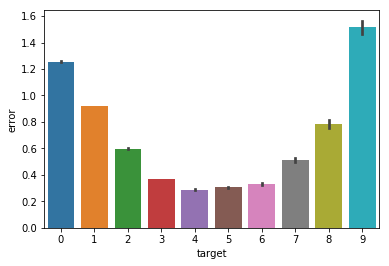

In [114]:
sns.barplot(x="target", y="error", data=data)

In [118]:
data[change2none+["error"]].groupby("error").count()

,date,kp_h_x,Np_,Tp_,Vp_,B_gsm_x,B_gsm_y,B_gsm_z,Bmag,target
error,,,,,,,,,,
0,4610434,4610434,4610434,4610434,4610434,4610434,4610434,4610434,4610434,4610434
1,1007886,1007886,23408,992877,999487,1007886,1007886,1007886,1007886,1007886
2,1297292,1297292,217,3106,1293969,1297292,1297292,1297292,1297292,1297292
3,513892,513892,0,0,0,513892,513892,513892,513892,513892


> Np, Tp, Vp가 모두 결측값인 경우는 예측에 영향을 줄 것 같다.

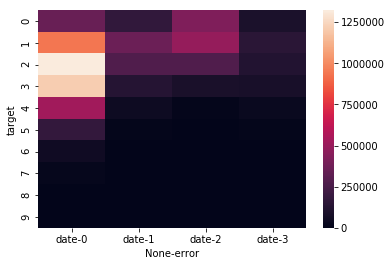

In [126]:
sns.heatmap(data[["target", "error", "date"]].groupby(["target", "error"]).count().unstack())

In [9]:
# 세개 다 error일때만 1로 한다.

data["error2"] = data["error"].map({0:1, 1:0, 2:0, 3:0})

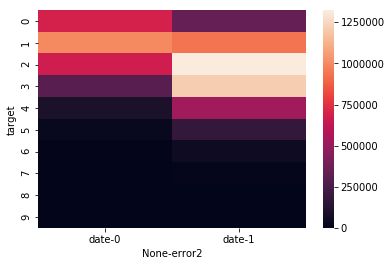

In [134]:
sns.heatmap(data[["target", "error2", "date"]].groupby(["target", "error2"]).count().unstack())

> 시간은 중요한 변수가 아닌 것 같다.

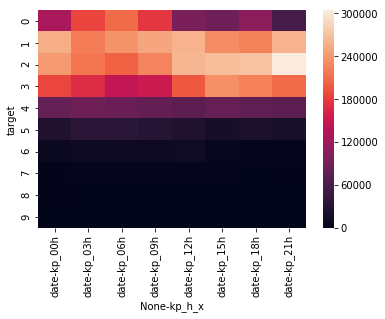

In [131]:
sns.heatmap(data[["target", "kp_h_x", "date"]].groupby(["target", "kp_h_x"]).count().unstack())

In [10]:
try1 = data[["Vp_","B_gsm_x", "B_gsm_y", "B_gsm_z", "Bmag", "error", "target"]]

# 결측값 채우기

In [11]:
try1["Vp_"] = try1.Vp_.interpolate()

C:\Users\JINHYO\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
try1.head()

,Vp_,B_gsm_x,B_gsm_y,B_gsm_z,Bmag,error,target
0,406.00,-2.174,-2.598,5.550,6.630,0,0
1,419.12,-1.245,-0.140,6.558,6.796,0,0
2,411.99,-2.003,-1.198,6.306,6.802,0,0
3,405.25,-3.093,-2.483,5.545,6.854,0,0
4,406.76,-3.009,-1.500,5.908,6.842,3,0


---

# B_gsm_x, B_gsm_y, B_gsm_z, Bmag 컬럼을 3시간 단위로  min, median 처리

In [15]:
try1 = pd.concat([data[["date", "kp_h_x"]], try1], axis=1)

In [44]:
try1_min = try1.iloc[:,:-2].groupby(["date", "kp_h_x"]).min().reset_index(drop=True)

In [45]:
minCol = {_:_+"_min" for _ in try1_min.columns}

In [46]:
try1_min.rename(columns=meanCol, inplace=True)

In [47]:
try1_median = try1.iloc[:,:-2].groupby(["date", "kp_h_x"]).median().reset_index(drop=True)

In [48]:
medianCol = {_:_+"_median" for _ in try1_median.columns}

In [49]:
try1_median.rename(columns=medianCol, inplace=True)

# error 컬럼을 3시간 단위로 mean 처리

In [56]:
try1_error = try1[["date", "kp_h_x", "error"]].groupby(["date", "kp_h_x"]).mean().reset_index(drop=True)

In [57]:
fdata = pd.concat([try1_min, try1_median, try1_error], axis=1)

---

# target 데이터 전처리

In [65]:
def target_melt(target:pd.DataFrame, year:int) -> pd.DataFrame :
    """지자기교란 지수 데이터를 column 1개로 만들어준다. 
    
    parameters
    -----------
    - target: 지자기교란 지수 DataFrame.
    - date: 필요한 연도.
    """
    # 연도 잘라내기
    target["index"] = target.date
    target = target.set_index("index").loc[f"{year}-01-01":f"{year}-12-31"]
    
    # kp_h명 바꾸기
    cols = {
        "kp_0h":"kp_00h",
        "kp_3h":"kp_03h",
        "kp_6h":"kp_06h",
        "kp_9h":"kp_09h",
    }
    target.rename(columns=cols, inplace=True)
        
    # melt
    return target.melt("date").sort_values(["date", "variable"]).reset_index(drop=True)

In [85]:
target_melted = {k: target_melt(target, k) for k in range(1999,2014)}

In [86]:
target_melted = pd.concat(target_melted.values(), axis=0).reset_index(drop=True)

In [87]:
target_melted.head()

,date,variable,value
0,1999-01-01,kp_00h,0
1,1999-01-01,kp_03h,2
2,1999-01-01,kp_06h,1
3,1999-01-01,kp_09h,2
4,1999-01-01,kp_12h,2


In [88]:
len(fdata), len(target_melted)

(43832, 43832)

In [89]:
fdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43832 entries, 0 to 43831
Data columns (total 11 columns):
Vp__mean          43832 non-null float64
B_gsm_x_mean      43832 non-null float64
B_gsm_y_mean      43832 non-null float64
B_gsm_z_mean      43832 non-null float64
Bmag_mean         43832 non-null float64
Vp__median        43832 non-null float64
B_gsm_x_median    43832 non-null float64
B_gsm_y_median    43832 non-null float64
B_gsm_z_median    43832 non-null float64
Bmag_median       43832 non-null float64
error             43832 non-null float64
dtypes: float64(11)
memory usage: 3.7 MB


In [90]:
target_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43832 entries, 0 to 43831
Data columns (total 3 columns):
date        43832 non-null object
variable    43832 non-null object
value       43832 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


---

# train 데이터와 target 데이터 합치기

In [ ]:
fdata = pd.concat([fdata, target_melted], axis=1)

In [96]:
fdata = fdata.drop(columns=["date", "variable"]).rename(columns={"value":"target"})

---

# 평가함수

In [58]:
import math

In [102]:
def weightedRMSE(model, test):
    """홈페이지에 공지된 평가기준"""
    ks = test.target.to_numpy()
    kps = model.predict(test.iloc[:,:-1])
    sum_temp = 0
    n = sum(ks)

    for k, kp in zip(ks, kps):
        temp = ((kp-k)**2) * (k/n)
        sum_temp += temp

    return math.sqrt(sum_temp)

---

# train test split

In [97]:
split = 365*8

train = fdata[:-split]
test = fdata[-split:]

----

# 모델

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
lr_l1 = LogisticRegression(penalty='l1')

In [99]:
lr_l1.fit(train.iloc[:,:-1], train.target)

C:\Users\JINHYO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JINHYO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\JINHYO\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [103]:
weightedRMSE(lr_l1, test)

0.9918671031255697

In [155]:
l1_pred = lr_l1.predict(test.iloc[:,:-1])

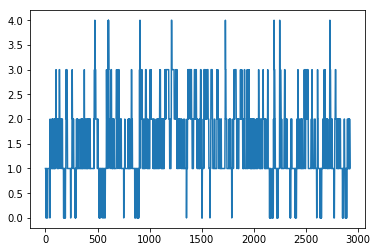

In [156]:
plt.plot(l1_pred)

---

# problem 전처리

In [104]:
problem["error"] = problem["Np"].map(lambda x: 1 if x < 0 else 0) + \
                problem["Tp"].map(lambda x: 1 if x < 0 else 0) + \
                problem["Vp"].map(lambda x: 1 if x < 0 else 0)

In [116]:
problem.head()

,doy,h,m,Np,Tp,Vp,B_gsm_x,B_gsm_y,B_gsm_z,Bmag,error,Vp_
0,1,kp_00h,0,1.852,41618.0,455.61,6.098,2.449,-13.415,14.952,0,455.61
1,1,kp_00h,1,2.181,33781.0,461.07,6.700,1.502,-13.232,14.912,0,461.07
2,1,kp_00h,2,2.415,34709.0,464.84,7.390,0.523,-12.941,14.928,0,464.84
3,1,kp_00h,3,2.359,34183.0,470.76,8.011,-0.098,-12.694,15.013,0,470.76
4,1,kp_00h,4,1.237,32467.0,469.51,7.493,0.410,-13.058,15.064,0,469.51


In [108]:
problem["Vp_"] = problem.Vp.map(lambda x: None if x<0 else x)

In [109]:
problem["Vp_"] = problem.Vp_.interpolate()

In [112]:
problem["h"] = problem["h"].map({
                        0:"kp_00h",    1:"kp_00h",    2:"kp_00h",
                        3:"kp_03h",    4:"kp_03h",    5:"kp_03h",
                        6:"kp_06h",    7:"kp_06h",    8:"kp_06h",
                        9:"kp_09h",    10:"kp_09h",    11:"kp_09h",
                        12:"kp_12h",    13:"kp_12h",    14:"kp_12h",
                        15:"kp_15h",    16:"kp_15h",    17:"kp_15h",
                        18:"kp_18h",    19:"kp_18h",    20:"kp_18h",
                        21:"kp_21h",    22:"kp_21h",    23:"kp_21h",
                                  })

In [115]:
problem_error = problem[["doy", "h", "error"]].groupby(["doy", "h"]).mean().reset_index(drop=True)

In [118]:
problem_min = problem[["doy", "h", "Vp_", "B_gsm_x", "B_gsm_y", "B_gsm_z", "Bmag"]].groupby(["doy", "h"]).min().reset_index(drop=True)

In [119]:
minCol = {_:_+"_min" for _ in problem_min.columns}

In [120]:
problem_min.rename(columns=meanCol, inplace=True)

In [121]:
problem_median = problem[["doy", "h", "Vp_", "B_gsm_x", "B_gsm_y", "B_gsm_z", "Bmag"]].groupby(["doy", "h"]).median().reset_index(drop=True)

In [122]:
medianCol = {_:_+"_median" for _ in problem_median.columns}

In [123]:
problem_median.rename(columns=medianCol, inplace=True)

In [129]:
problem = pd.concat([problem_median, problem_min, problem_error], axis=1)

---

# 결과 제출

In [130]:
re = lr_l1.predict(problem)

In [133]:
result = re

In [134]:
result = result.reshape((-1, 8))
result = pd.DataFrame(result, columns=target.columns[1:-1], index=range(1, len(result)+1))
result.head()

,kp_0h,kp_3h,kp_6h,kp_9h,kp_12h,kp_15h,kp_18h,kp_21h
1,3,3,3,1,2,2,1,1
2,2,2,2,2,1,2,2,1
3,1,2,2,2,2,2,1,1
4,1,2,1,1,1,2,2,1
5,1,1,2,2,1,2,2,3


In [135]:
result.to_csv("result.csv")

## knn

In [136]:
from sklearn.neighbors import KNeighborsClassifier

In [152]:
knn5 = KNeighborsClassifier(n_neighbors=50)
knn300 = KNeighborsClassifier(n_neighbors=150)

In [153]:
knn5.fit(train.iloc[:,:-1], train.target)
knn300.fit(train.iloc[:,:-1], train.target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=150, p=2,
           weights='uniform')

In [154]:
weightedRMSE(knn5, test)

1.0397106562339973

In [151]:
weightedRMSE(knn300, test)

1.054346354229018

In [141]:
len(train)

40912

---